In [33]:
import gym
import torch
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F

from tqdm.notebook import tqdm

np.random.seed(0)
torch.manual_seed(0)

In [4]:
env = gym.make('CartPole-v0')
env.seed(0)

[0]

In [7]:
class DQN(nn.Module):
    
    def __init__(self, input_size, hidden_sizes, output_size):
        super(DQN, self).__init__()
        
        neurons = [input_size] + hidden_sizes
        layers = []
        for i in range(len(neurons) - 1):
            layers.append(nn.Linear(neurons[i], neurons[i + 1]))
            layers.append(nn.ReLU(inplace=True))
        layers.append(nn.Linear(neurons[-1], output_size))
        layers.append(nn.Softmax())
        self.net = nn.Sequential(*layers)
        return

    def forward(self, x):
        return self.net(x)

In [50]:
# 同策策略梯度算法智能体类

class VPGAgent(object):
    
    def __init__(self, env, policy_kwargs, baseline_kwargs=None, gamma=0.99):
        observation_dim = env.observation_space.shape[0]
        self.action_n = env.action_space.n
        self.gamma = gamma
        
        self.trajectory = []

        self.policy_net = DQN(observation_dim, policy_kwargs['hidden_sizes'], self.action_n)
        self.policy_opt = optim.Adam(self.policy_net.parameters(), lr=policy_kwargs['learning_rate'])
        
        if baseline_kwargs:
            self.baseline_net = DQN(observation_dim, baseline_kwargs['hidden_sizes'], 1)
            self.baseline_opt = optim.Adam(self.baseline_net.parameters(), lr=baseline_kwargs['learning_rate'])
        return

    @staticmethod
    def __tensor2numpy(tensor):
        return tensor.cpu().detach().numpy()
    
    def decide(self, observation):
        self.policy_net.eval()
        probs = self.policy_net(torch.tensor(observation[np.newaxis]).float())
        probs = self.__tensor2numpy(probs)[0]
        action = np.random.choice(self.action_n, p=probs)
        return action
    
    def learn(self, observation, action, reward, done):
        self.trajectory.append((observation, action, reward))
        
        if done:
            df = pd.DataFrame(data=self.trajectory, columns=['observation', 'action', 'reward'])
            df['discount'] = self.gamma ** df.index.to_series()
            df['discounted_reward'] = df['discount'] * df['reward']
            df['discounted_return'] = df['discounted_reward'][::-1].cumsum()
            df['psi'] = df['discounted_return']
            
            x = torch.tensor(np.stack(df['observation'])).float()
            if hasattr(self, 'baseline_net'):
                self.baseline_net.eval()
                df['baseline'] = self.__tensor2numpy(self.baseline_net(x))
                df['psi'] -= df['baseline'] * df['discount']
                df['return'] = df['discount_return'] / df['discount']
                y = torch.tensor(df['return'].values[:, np.newaxis]).float()
                self.baseline_net.train()
                y_hat = self.baseline_net(x)
                loss = F.binary_cross_entropy_with_logits(y_hat, y)
                self.baseline_opt.zero_grad()
                loss.backward()
                self.baseline_opt.step()
            
            y = torch.tensor(np.eye(self.action_n)[df['action']] * df['psi'].values[:, np.newaxis]).float()
            self.policy_net.train()
            y_hat = self.policy_net(x)
            loss = F.binary_cross_entropy_with_logits(y_hat, y)
            self.policy_opt.zero_grad()
            loss.backward()
            self.policy_opt.step()

            self.trajectory = []
        return

In [16]:
# 智能体和环境交互一个回合的代码

def play_montecarlo(env, agent, render=False, train=False):
    episode_reward = 0.0
    observation = env.reset()
    
    while True:
        if render:
            env.render()
        
        action = agent.decide(observation)
        next_observation, reward, done, _ = env.step(action)
        episode_reward += reward
        
        if train:
            agent.learn(observation, action, reward, done)
        if done:
            break
        
        observation = next_observation
    
    return episode_reward

d:\programdata\miniconda3\envs\rl\lib\site-packages\torch\nn\modules\container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


平均回合奖励 = 950.0 / 100 = 9.5


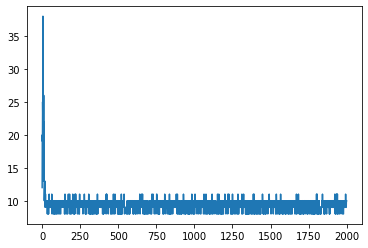

In [51]:
# 不带基线的简单策略梯度算法

policy_kwargs = dict(hidden_sizes=[128,], learning_rate=0.01)
agent = VPGAgent(env, policy_kwargs=policy_kwargs)

# 训练
episodes = 2000
episode_rewards = []
for episode in tqdm(range(episodes)):
    episode_reward = play_montecarlo(env, agent, train=True)
    episode_rewards.append(episode_reward)
plt.plot(episode_rewards)

# 测试
episode_rewards = [play_montecarlo(env, agent, train=False) for _ in range(100)]
print('平均回合奖励 = {} / {} = {}'.format(sum(episode_rewards), len(episode_rewards), np.mean(episode_rewards)))